In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd
import os

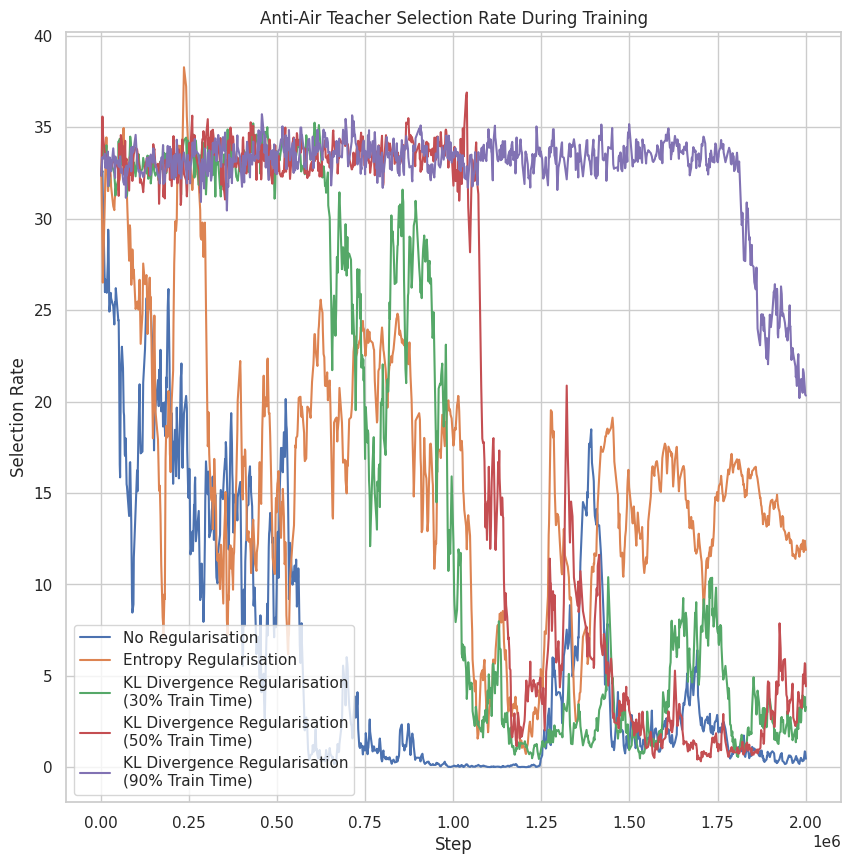

In [26]:
# Plot training data against each other
sns.set_theme(style="whitegrid")
plots_paths = [
    "final_fusion_policies/soft_weights/tb_data/seed_0_def_rate.json",
    "final_fusion_policies/soft_weights_ent_0-01/tb_data/def_rate.json",
    "final_fusion_policies/soft_weights_kl_frac_0-3/tb_data/def_rate.json",
    "final_fusion_policies/soft_weights_kl_frac_0-5/tb_data/seed_0_def.json",
    "final_fusion_policies/soft_weights_kl_frac_0-9/tb_data/seed_0_def.json",
]
runs = []
labels = [
    "No Regularisation",
    "Entropy Regularisation",
    "KL Divergence Regularisation\n(30% Train Time)",
    "KL Divergence Regularisation\n(50% Train Time)",
    "KL Divergence Regularisation\n(90% Train Time)",
]
for idx, path in enumerate(plots_paths):
    with open(path) as f:
        results = json.load(f)
        df = pd.DataFrame(data=results, columns=["col0", "x","y"])
        sns.lineplot(data=df, x="x", y="y", errorbar=None, label=labels[idx], legend=True)
plt.xlabel("Step")
plt.ylabel("Selection Rate")
plt.title("Anti-Air Teacher Selection Rate During Training")#
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

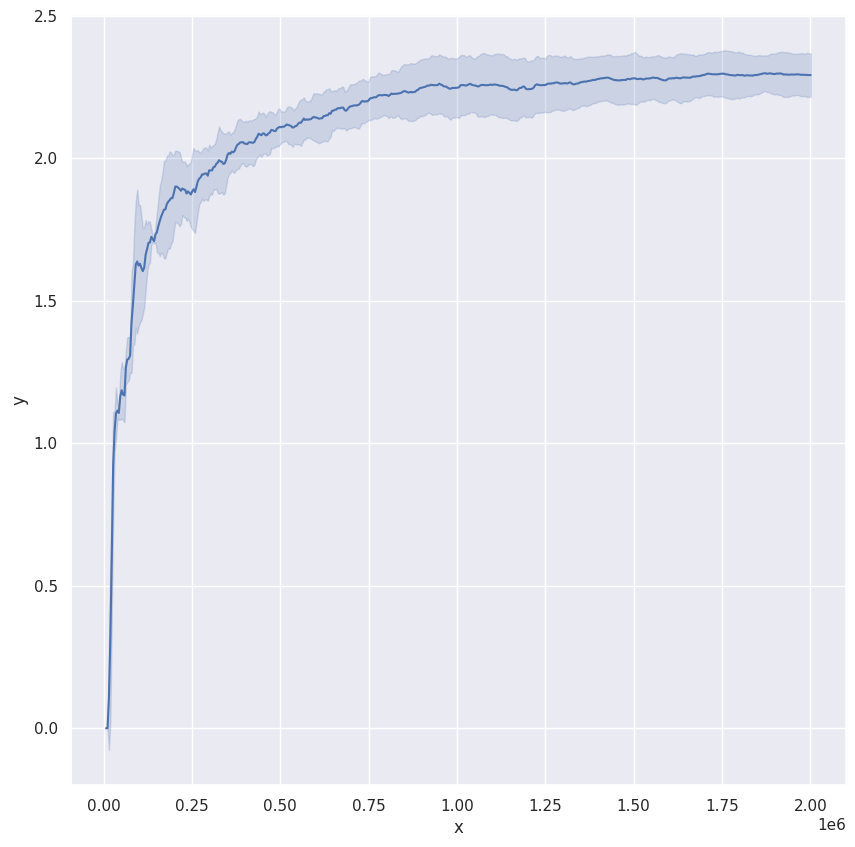

In [11]:
# Average data over multiple training sessions
def to_df(data, run_id):
    return pd.DataFrame(data, columns=['col0', 'x', 'y']).assign(run=run_id)

sns.set_theme(style="darkgrid")
plots_paths = [
    "final_fusion_policies/soft_weights/tb_data/seed_0_stages.json",
    "final_fusion_policies/soft_weights/tb_data/seed_100_stages.json",
    "final_fusion_policies/soft_weights/tb_data/seed_500_stages.json",
]
runs = []
for i, path in enumerate(plots_paths):
    with open(path) as f:
        results = json.load(f)
        runs.append(to_df(results, f"run{i}"))

all_x = pd.concat([df['x'] for df in runs])
x_common = np.linspace(all_x.min(), all_x.max(), 500)
interpolated_dfs = []
for df in runs:
    interp_y = np.interp(x_common, df['x'], df['y'])
    interpolated_dfs.append(pd.DataFrame({'x': x_common, 'y': interp_y}))
for i, df in enumerate(interpolated_dfs):
    df['run'] = f'run{i+1}'
df_all = pd.concat(interpolated_dfs, ignore_index=True)
save_dir = "averaged_tb_data"
os.makedirs(save_dir, exist_ok=True)
file_name = "fusenet_stages_seeds-3.json"
df_all.to_json(
    path_or_buf=os.path.join(save_dir, file_name),
    orient="records",
    lines=False,
    indent=2,
)
sns.lineplot(data=df_all, x="x", y="y", errorbar="sd")
plt.show()

In [30]:
results_paths = [
    "base_policies/ryu_vanilla/evaluations/seed_0/det_arcade/results.json",
    "base_policies/ryu_vanilla/evaluations/seed_0/sto_arcade/results.json",
    "base_policies/rl_teacher_obs/evaluations/seed_0/deterministic/results.json",
    "base_policies/rl_teacher_obs/evaluations/seed_0/stochastic/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_0/soft_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_0/hard_weights_det/results.json",
    # "final_fusion_policies/soft_weights_ent_0-01/evaluations/seed_0/hard_weights_det/results.json",
    # "final_fusion_policies/soft_weights_ent_0-01/evaluations/seed_0/soft_weights_det/results.json",
    # "final_fusion_policies/soft_weights_kl_frac_0-3/evaluations/seed_0/hard_weights_det/results.json",
    # "final_fusion_policies/soft_weights_kl_frac_0-3/evaluations/seed_0/soft_weights_det/results.json",
    # "final_fusion_policies/soft_weights_kl_frac_0-5/evaluations/seed_0/hard_weights_det/results.json",
    # "final_fusion_policies/soft_weights_kl_frac_0-5/evaluations/seed_0/soft_weights_det/results.json",
    # "final_fusion_policies/soft_weights_kl_frac_0-9/evaluations/seed_0/hard_weights_det/results.json",
    # "final_fusion_policies/soft_weights_kl_frac_0-9/evaluations/seed_0/soft_weights_det/results.json",
]
reward_infos = []
stages_infos = []
# arcade_infos = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        reward_infos.append(results["rewards_infos"])
        stages_infos.append(results["stages_infos"])
        # arcade_infos.append(results["arcade_runs_infos"])
all_results = [reward_infos, stages_infos]

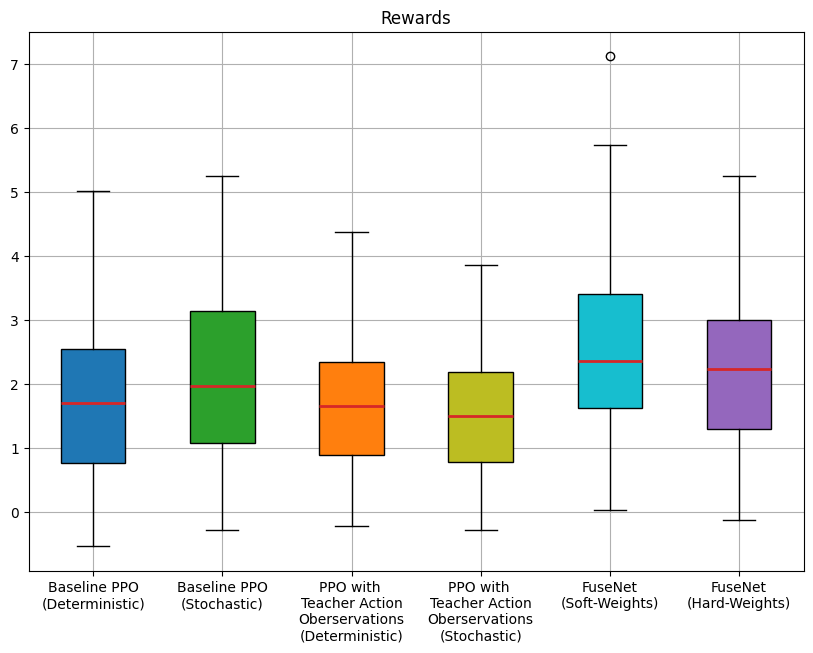

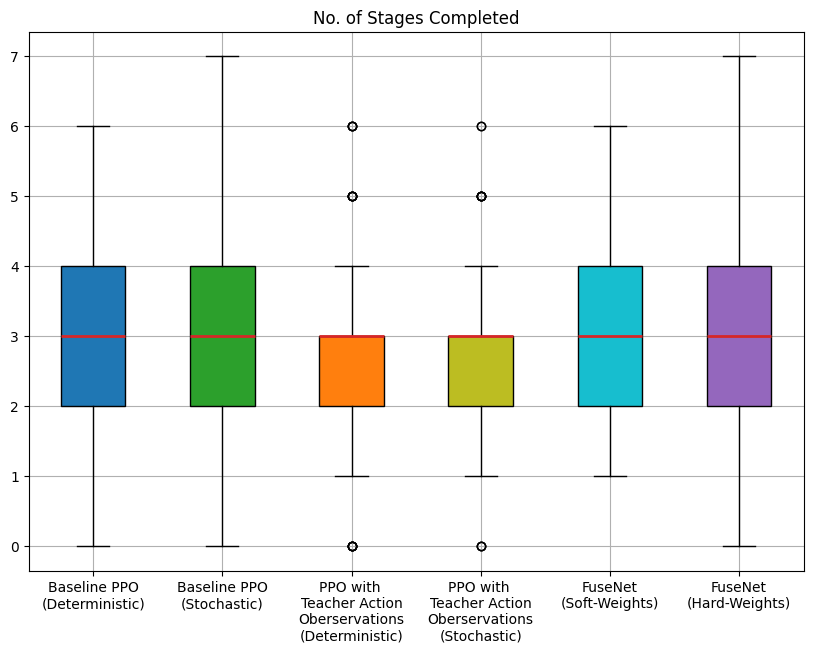

In [33]:
titles = ["Rewards", "No. of Stages Completed", "No. of Arcade Runs Completed"]
colors = ["tab:blue","tab:green","tab:orange","tab:olive","tab:cyan","tab:purple","tab:brown","tab:pink","tab:gray"]
x_tick_labels = [
    "Baseline PPO\n(Deterministic)",
    "Baseline PPO\n(Stochastic)",
    "PPO with \nTeacher Action\nOberservations\n(Deterministic)",
    "PPO with \nTeacher Action\nOberservations\n(Stochastic)",
    "FuseNet\n(Soft-Weights)",
    "FuseNet\n(Hard-Weights)",
    # "FuseNet w/ entropy\n(Soft-Weights)",
    # "FuseNet w/ entropy\n(Hard-Weights)",
    # "KL regulation\n30% Train Time\n(Soft-Weights)",
    # "KL regulation\n30% Train Time\n(Hard-Weights)",
    # "KL regulation\n50% Train Time\n(Soft-Weights)",
    # "KL regulation\n50% Train Time\n(Hard-Weights)",
    # "KL regulation\n90% Train Time\n(Soft-Weights)",
    # "KL regulation\n90% Train Time\n(Hard-Weights)",
]
for idx, results in enumerate(all_results):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(
        results,
        patch_artist=True,
        notch=False,
        vert=0
    )
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
    for median in bp["medians"]:
        median.set(color="tab:red", linewidth=2)
    ax.set_title(titles[idx])
    ax.set_xticklabels(x_tick_labels)
    ax.grid()
    plt.show()

In [11]:
results_paths = [
    "final_fusion_policies/soft_weights_kl_frac_0-9/evaluations/seed_0/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights_kl_frac_0-9/evaluations/seed_0/soft_weights_det/results.json",
]
teacher_sim_means = []
teacher_sim_stds = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        teacher_sim_means.append(results["teacher_likelihood_means"])
        teacher_sim_stds.append(results["teacher_likelihood_stds"])

for s_idx, means_and_stds in enumerate(zip(teacher_sim_means, teacher_sim_stds)):
    means, stds = means_and_stds
    print("-----------------------------------------------------------------")
    for t_id in means.keys():
        print(f"\nAvg likelihood of student {s_idx + 1} picking the same action as {t_id}:")
        act_means = means[t_id]
        act_stds = stds[t_id]
        for a_idx, act_info in enumerate(zip(act_means, act_stds)):
            act_mean, act_std = act_info
            act_mean = round(act_mean[0] * 100, 3)
            act_std = round(act_std[0] * 100, 3)
            print(f"Action {a_idx}: {act_mean}% +/- {act_std}")
    print("\n-----------------------------------------------------------------")

-----------------------------------------------------------------

Avg likelihood of student 1 picking the same action as antiair_teacher:
Action 0: 100.0% +/- 0.0
Action 1: 100.0% +/- 0.0

Avg likelihood of student 1 picking the same action as attack_teacher:
Action 0: 0.0% +/- 0.0
Action 1: 0.0% +/- 0.0

Avg likelihood of student 1 picking the same action as defence_teacher:
Action 0: 0.0% +/- 0.0
Action 1: 0.0% +/- 0.0

-----------------------------------------------------------------
-----------------------------------------------------------------

Avg likelihood of student 2 picking the same action as antiair_teacher:
Action 0: 93.402% +/- 0.046
Action 1: 0.0% +/- 0.0

Avg likelihood of student 2 picking the same action as attack_teacher:
Action 0: 6.582% +/- 0.046
Action 1: 99.849% +/- 0.007

Avg likelihood of student 2 picking the same action as defence_teacher:
Action 0: 0.017% +/- 0.002
Action 1: 0.0% +/- 0.0

-----------------------------------------------------------------


In [ ]:
results_paths = [
    "final_fusion_policies/soft_weights/evaluations/seed_0/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_0/soft_weights_det/results.json",
]
kl_divs = []
kl_means = []
kl_stds = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        kl_divs.append(results["kl_divergences"])
        kl_means.append(results["mean_kl_divs"])
        kl_stds.append(results["std_kl_divs"])
        
print("----------------------------------------------------------------")
for s_idx, means_and_stds in enumerate(zip(kl_means, kl_stds)):
    means, stds = means_and_stds
    for t_id in means.keys():
        print(f"KL divergence between student {s_idx + 1} and {t_id}: {means[t_id]:.3f} +/- {stds[t_id]:.5f}")
    print("----------------------------------------------------------------")

----------------------------------------------------------------
KL divergence between student 1 and antiair_teacher: 3.081 +/- 0.44161
KL divergence between student 1 and attack_teacher: 0.000 +/- 0.00000
KL divergence between student 1 and defence_teacher: 5.513 +/- 0.76406
----------------------------------------------------------------
KL divergence between student 2 and antiair_teacher: 2.847 +/- 0.40763
KL divergence between student 2 and attack_teacher: 0.002 +/- 0.00161
KL divergence between student 2 and defence_teacher: 5.183 +/- 0.68082
----------------------------------------------------------------
